In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from SI_Classes import SI_model, GPSS , DataScaler
from System_Classes import CascadedTankSystem, LTISystem, WHSystem, CascadedTankSystem_Simplified
from SI_Functions import perform_experiment, generate_input_signals, generate_random_input_signals
# Set seed for reproducibility
seed=1
# seed=42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# True system - Cascaded Tanks
x0_denorm = np.array([5, 5])
#Receiving Input/Output Data for Cascaded Tanks
dataset = pd.read_csv("dataBenchmark.csv")
dataset = dataset.rename(
    columns={
        "uEst": "u_train",
        "uVal": "u_test",
        "yEst": "y_train",
        "yVal": "y_test",
    }
)

# Using Benchmark Data for Training and Testing
u_fit_denorm       = np.array(dataset["u_train"]).reshape(-1, 1)
y_fit_true_denorm  = np.array(dataset["y_train"]).reshape(-1, 1)
u_test_denorm      = np.array(dataset["u_test"][6:]).reshape(-1, 1)
y_test_true_denorm = np.array(dataset["y_test"][6:]).reshape(-1, 1)

In [3]:
datascaler = DataScaler(
    mu_u=np.mean(u_fit_denorm, axis=0),
    mu_y=np.mean(y_fit_true_denorm, axis=0), 
    mu_x=np.mean(y_fit_true_denorm, axis=0),
    std_u=np.std(u_fit_denorm, axis=0),
    std_y=np.std(y_fit_true_denorm, axis=0), 
    std_x=np.std(y_fit_true_denorm, axis=0),
    mu_offset_u=0*np.mean(u_fit_denorm, axis=0),
    mu_offset_y=0*np.mean(y_fit_true_denorm, axis=0), 
    mu_offset_x=0*np.mean(y_fit_true_denorm, axis=0),  
    )

# Normalizing the Data
u_fit       = datascaler.normalize(u_fit_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
u_test      = datascaler.normalize(u_test_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
y_fit_true  = datascaler.normalize(y_fit_true_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_test_true = datascaler.normalize(y_test_true_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
x0          = datascaler.normalize(x0_denorm, datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x)
x0_fit      = x0
x0_test     = x0

In [4]:
# Setup neural model structure
n_x               = 2
n_u               = 1
n_y               = 1
hidden_size       = 16
tau_prior         = 0.3
sigma_noise       = 0.3
nn_fit_iters_base = 1000
nn_fit_lr_base    = 1e-2
n_samples         = 10

In [5]:
from NN_Classes import NeuralLinStateUpdate, NeuralLinOutput, CTSNeuralStateSpace, NeuralLinStateUpdate_2HLayer
si_model = SI_model(n_x, n_u, n_y, hidden_size, dtype=torch.float32, device=torch.device("cpu"), tau_prior=tau_prior, sigma_noise=sigma_noise, modify_si=False, f_class=NeuralLinStateUpdate_2HLayer, g_class=NeuralLinOutput)
_, _, loss_fit = si_model.nn_fit(u_fit=u_fit , y_fit=y_fit_true, x0=x0_fit, num_iter=nn_fit_iters_base, lr=nn_fit_lr_base, print_freq=25, return_loss=True)
_, _, _, _, _, _, _, _ = si_model.compute_fit_cov(u_fit=u_fit, x0_fit=x0_fit)
suprise_index_norm_fit,  cunc_std_norm_fit,  suprise_index_fit,  y_query_fit,  unc_std_fit, ppd_std_fit   = si_model.query(u_query=u_fit,  x0_query=x0_test)
suprise_index_norm_test, cunc_std_norm_test, suprise_index_test, y_query_test, unc_std_test, ppd_std_test = si_model.query(u_query=u_test, x0_query=x0_test)

suprise_index_norm_mc_fit,  cunc_std_norm_mc_fit,  suprise_index_mc_fit,  y_query_mc_fit,  unc_std_mc_fit, ppd_std_mc_fit   = si_model.mc_query(u_query=u_fit,  x0_query=x0_test, n_samples=n_samples)
suprise_index_norm_mc_test, cunc_std_norm_mc_test, suprise_index_mc_test, y_query_mc_test, unc_std_mc_test, ppd_std_mc_test = si_model.mc_query(u_query=u_test, x0_query=x0_test, n_samples=n_samples)

Iter 0 | Fit Loss 1.1053
Iter 25 | Fit Loss 0.4091
Iter 50 | Fit Loss 0.0506
Iter 75 | Fit Loss 0.0455
Iter 100 | Fit Loss 0.0424
Iter 125 | Fit Loss 0.0401
Iter 150 | Fit Loss 0.0378
Iter 175 | Fit Loss 0.0353
Iter 200 | Fit Loss 0.0327
Iter 225 | Fit Loss 0.0301
Iter 250 | Fit Loss 0.0275
Iter 275 | Fit Loss 0.0250
Iter 300 | Fit Loss 0.0226
Iter 325 | Fit Loss 0.0205
Iter 350 | Fit Loss 0.0186
Iter 375 | Fit Loss 0.0170
Iter 400 | Fit Loss 0.0155
Iter 425 | Fit Loss 0.0144
Iter 450 | Fit Loss 0.0134
Iter 475 | Fit Loss 0.0125
Iter 500 | Fit Loss 0.0118
Iter 525 | Fit Loss 0.0112
Iter 550 | Fit Loss 0.0107
Iter 575 | Fit Loss 0.0103
Iter 600 | Fit Loss 0.0099
Iter 625 | Fit Loss 0.0095
Iter 650 | Fit Loss 0.0092
Iter 675 | Fit Loss 0.0090
Iter 700 | Fit Loss 0.0087
Iter 725 | Fit Loss 0.0085
Iter 750 | Fit Loss 0.0083
Iter 775 | Fit Loss 0.0082
Iter 800 | Fit Loss 0.0080
Iter 825 | Fit Loss 0.0079
Iter 850 | Fit Loss 0.0077
Iter 875 | Fit Loss 0.0076
Iter 900 | Fit Loss 0.0075
Iter 9

In [6]:
# Gaussian Process Regression for State Prediction
lag_y = 25
lag_u = 25
gpss = GPSS(lag_y=lag_y, lag_u=lag_u)
y_query_gp_fit, ppd_std_gp_fit    = gpss.train_model(y=y_fit_true[:, 0], u=u_fit[:, 0], training_iter=300, lr=0.01, verbose=True)
y_query_gp_test, ppd_std_gp_test  = gpss.predict(u_test=u_test[lag_u:], y_hist_raw=y_test_true[:lag_y, :], u_hist_raw=u_test[:lag_u, :])

Iter 10/300 - Loss: 1.050
Iter 20/300 - Loss: 1.000
Iter 30/300 - Loss: 0.961
Iter 40/300 - Loss: 0.907
Iter 50/300 - Loss: 0.861
Iter 60/300 - Loss: 0.808
Iter 70/300 - Loss: 0.754
Iter 80/300 - Loss: 0.713
Iter 90/300 - Loss: 0.661
Iter 100/300 - Loss: 0.614
Iter 110/300 - Loss: 0.564
Iter 120/300 - Loss: 0.496
Iter 130/300 - Loss: 0.448
Iter 140/300 - Loss: 0.394
Iter 150/300 - Loss: 0.338
Iter 160/300 - Loss: 0.282
Iter 170/300 - Loss: 0.225
Iter 180/300 - Loss: 0.179
Iter 190/300 - Loss: 0.138
Iter 200/300 - Loss: 0.063
Iter 210/300 - Loss: 0.009
Iter 220/300 - Loss: -0.044
Iter 230/300 - Loss: -0.111
Iter 240/300 - Loss: -0.150
Iter 250/300 - Loss: -0.218
Iter 260/300 - Loss: -0.265
Iter 270/300 - Loss: -0.328
Iter 280/300 - Loss: -0.369
Iter 290/300 - Loss: -0.423
Iter 300/300 - Loss: -0.490


c:\Users\milad.banitalebi\AppData\Local\anaconda3\envs\sysid_env\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [7]:
y_fit_true_denorm      = datascaler.denormalize(y_fit_true, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_fit_denorm     = datascaler.denormalize(y_query_fit, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_test_denorm    = datascaler.denormalize(y_query_test, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_mc_fit_denorm  = datascaler.denormalize(y_query_mc_fit, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_mc_test_denorm = datascaler.denormalize(y_query_mc_test, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_gp_fit_denorm  = datascaler.denormalize(y_query_gp_fit, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_gp_test_denorm = datascaler.denormalize(y_query_gp_test, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_gp_fit_denorm  = datascaler.denormalize(y_query_gp_fit, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_query_gp_test_denorm = datascaler.denormalize(y_query_gp_test, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)

ppd_std_gp_fit_denorm  = ppd_std_gp_fit
ppd_std_gp_test_denorm = ppd_std_gp_test
ppd_std_fit_denorm     = ppd_std_fit
ppd_std_test_denorm    = ppd_std_test
ppd_std_mc_fit_denorm  = ppd_std_mc_fit
ppd_std_mc_test_denorm = ppd_std_mc_test

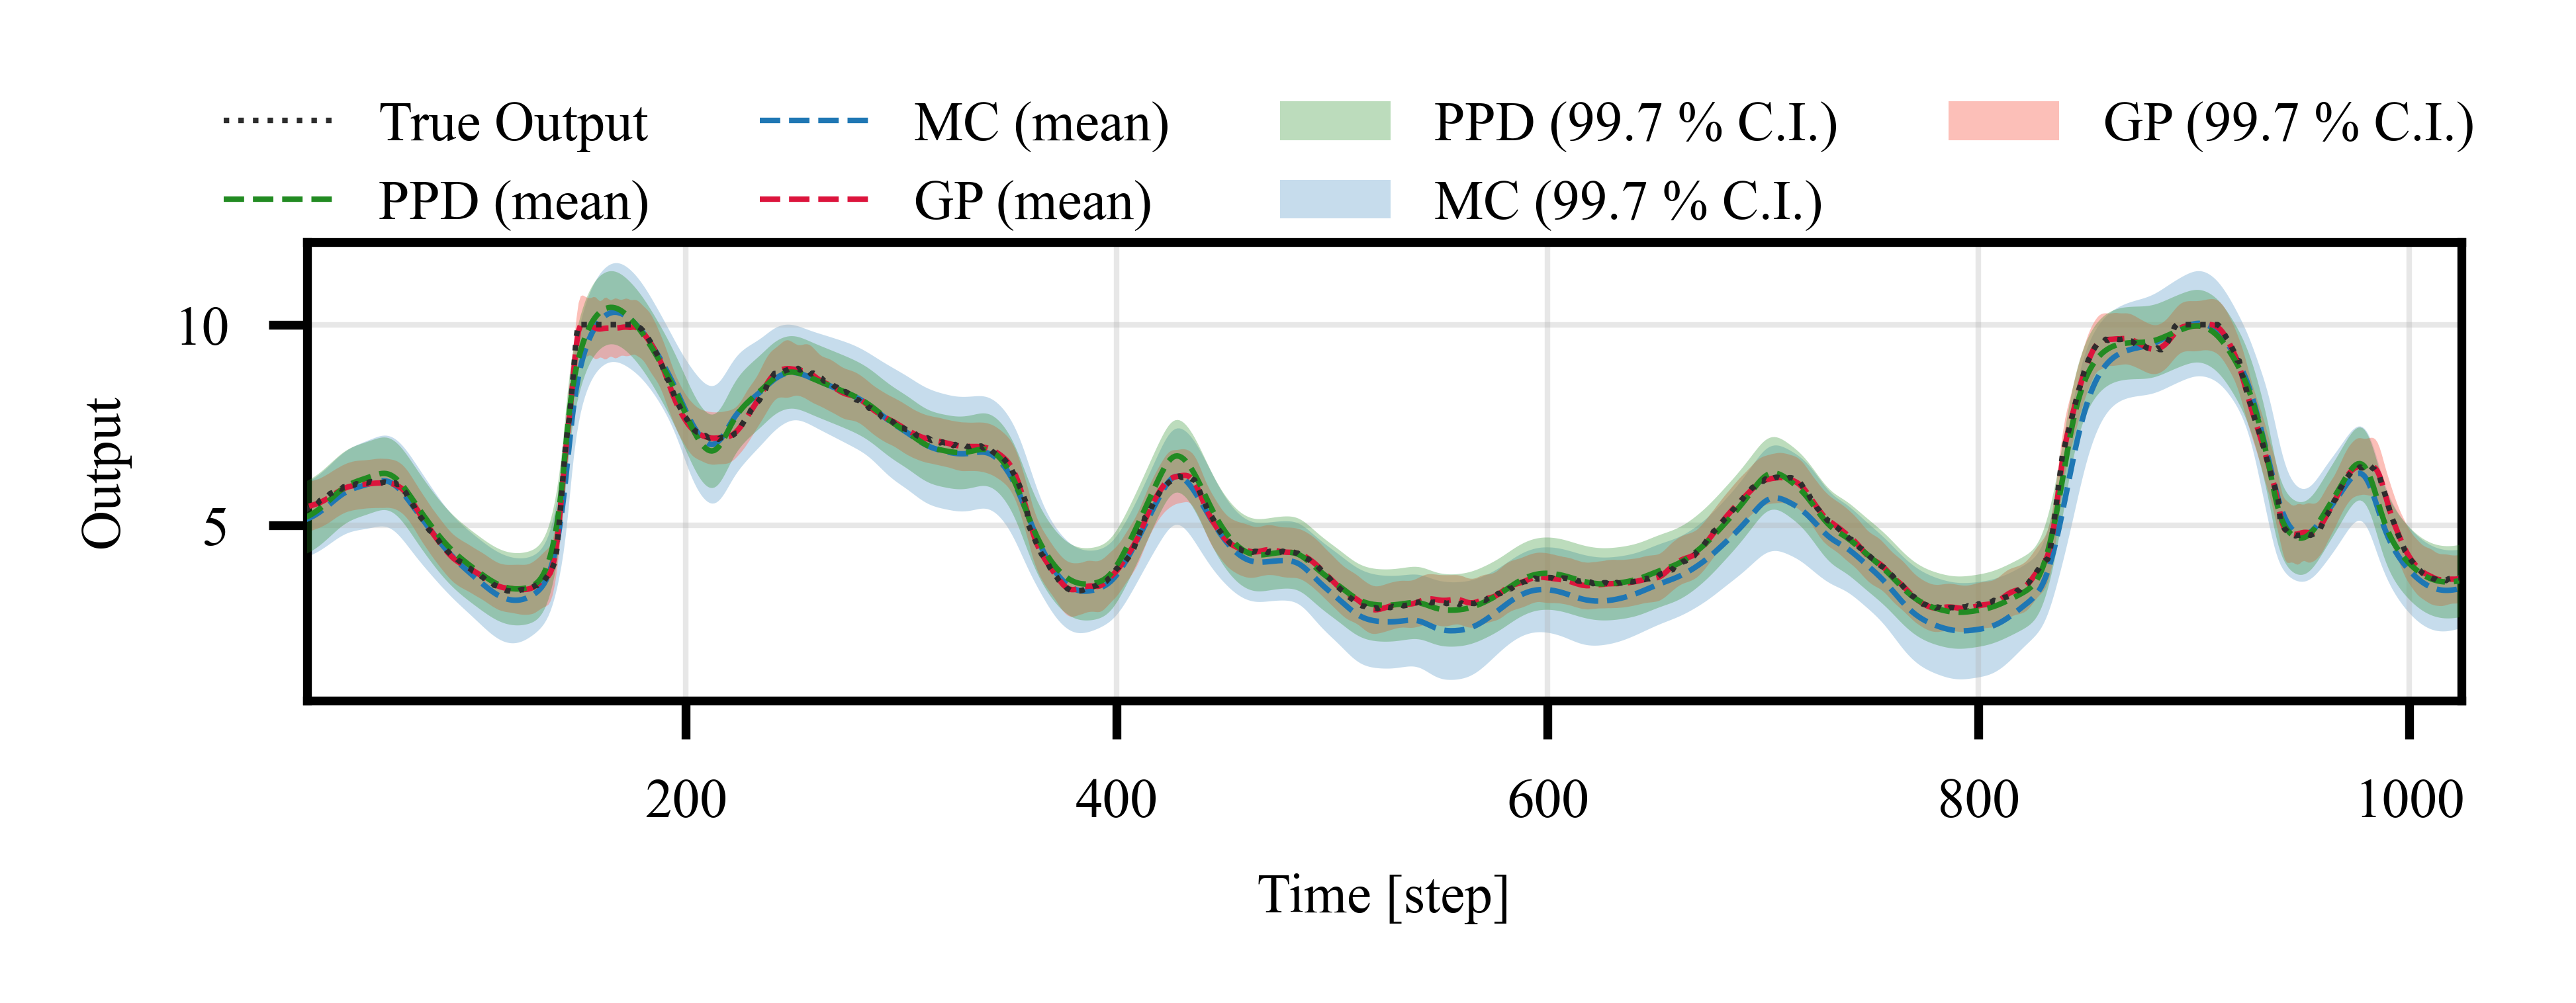

In [8]:
ppd_std_multiplier = 3
lw = 0.5  # Line width
dpi = 1200
fs = 5
# Configure font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = fs
plt.rcParams.update({'font.size': fs})
colors = ["#2D2D2D", "#1F77B4", "#228B22", "salmon", "blue", "#8AA7C1", "crimson"]

# Configure font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = fs
plt.rcParams.update({'font.size': fs})

fig, ax1 = plt.subplots(figsize=(3.5, 0.75), dpi=dpi)
ax1.plot(y_fit_true_denorm, label="True Output", linestyle=':', linewidth=lw,  color=colors[0], zorder=7)

ax1.plot(np.arange(y_query_fit_denorm.shape[0]), y_query_fit_denorm, label="PPD (mean)", linewidth=lw, linestyle='--', color=colors[2], zorder=6)

ax1.plot(np.arange(y_query_mc_fit_denorm.shape[0]), y_query_mc_fit_denorm, label="MC (mean)", linewidth=lw, linestyle='--', color=colors[1], zorder=4)

ax1.plot(np.arange(y_query_fit_denorm.shape[0])[lag_y: ], y_query_gp_fit_denorm, label="GP (mean)", linewidth=lw, linestyle='--', color=colors[6], zorder=5)

ax1.fill_between(np.arange(y_query_fit_denorm.shape[0]), y_query_fit_denorm.ravel() - ppd_std_multiplier * ppd_std_fit_denorm.ravel(),
                 y_query_fit_denorm.ravel() + ppd_std_multiplier * ppd_std_fit_denorm.ravel(),
                 color=colors[2], alpha=0.3, label="PPD (99.7 % C.I.)", linewidth=0, zorder=3)

ax1.fill_between(np.arange(y_query_mc_fit_denorm.shape[0]), y_query_mc_fit_denorm.ravel() - ppd_std_multiplier * ppd_std_mc_fit_denorm.ravel(),
                 y_query_mc_fit_denorm.ravel() + ppd_std_multiplier * ppd_std_mc_fit_denorm.ravel(),
                 color=colors[1], alpha=0.25, label="MC (99.7 % C.I.)", linewidth=0, zorder=1)

ax1.fill_between(np.arange(y_query_fit_denorm.shape[0])[lag_y:], y_query_gp_fit_denorm.ravel() - ppd_std_multiplier * ppd_std_gp_fit_denorm.ravel(),
                 y_query_gp_fit_denorm.ravel() + ppd_std_multiplier * ppd_std_gp_fit_denorm.ravel(),
                 color=colors[3], alpha=0.5, label="GP (99.7 % C.I.)", linewidth=0, zorder=2)

ax1.set_ylabel("Output")
ax1.set_xlabel("Time [step]")
ax1.set_xlim(lag_y-1, y_query_fit_denorm.shape[0])
ax1.grid(True, alpha=0.3, linewidth=0.5)

fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=4, fontsize=fs, frameon=False)
# plt.savefig('ExperimentDesign_Performance.pdf', dpi=dpi, bbox_inches='tight')


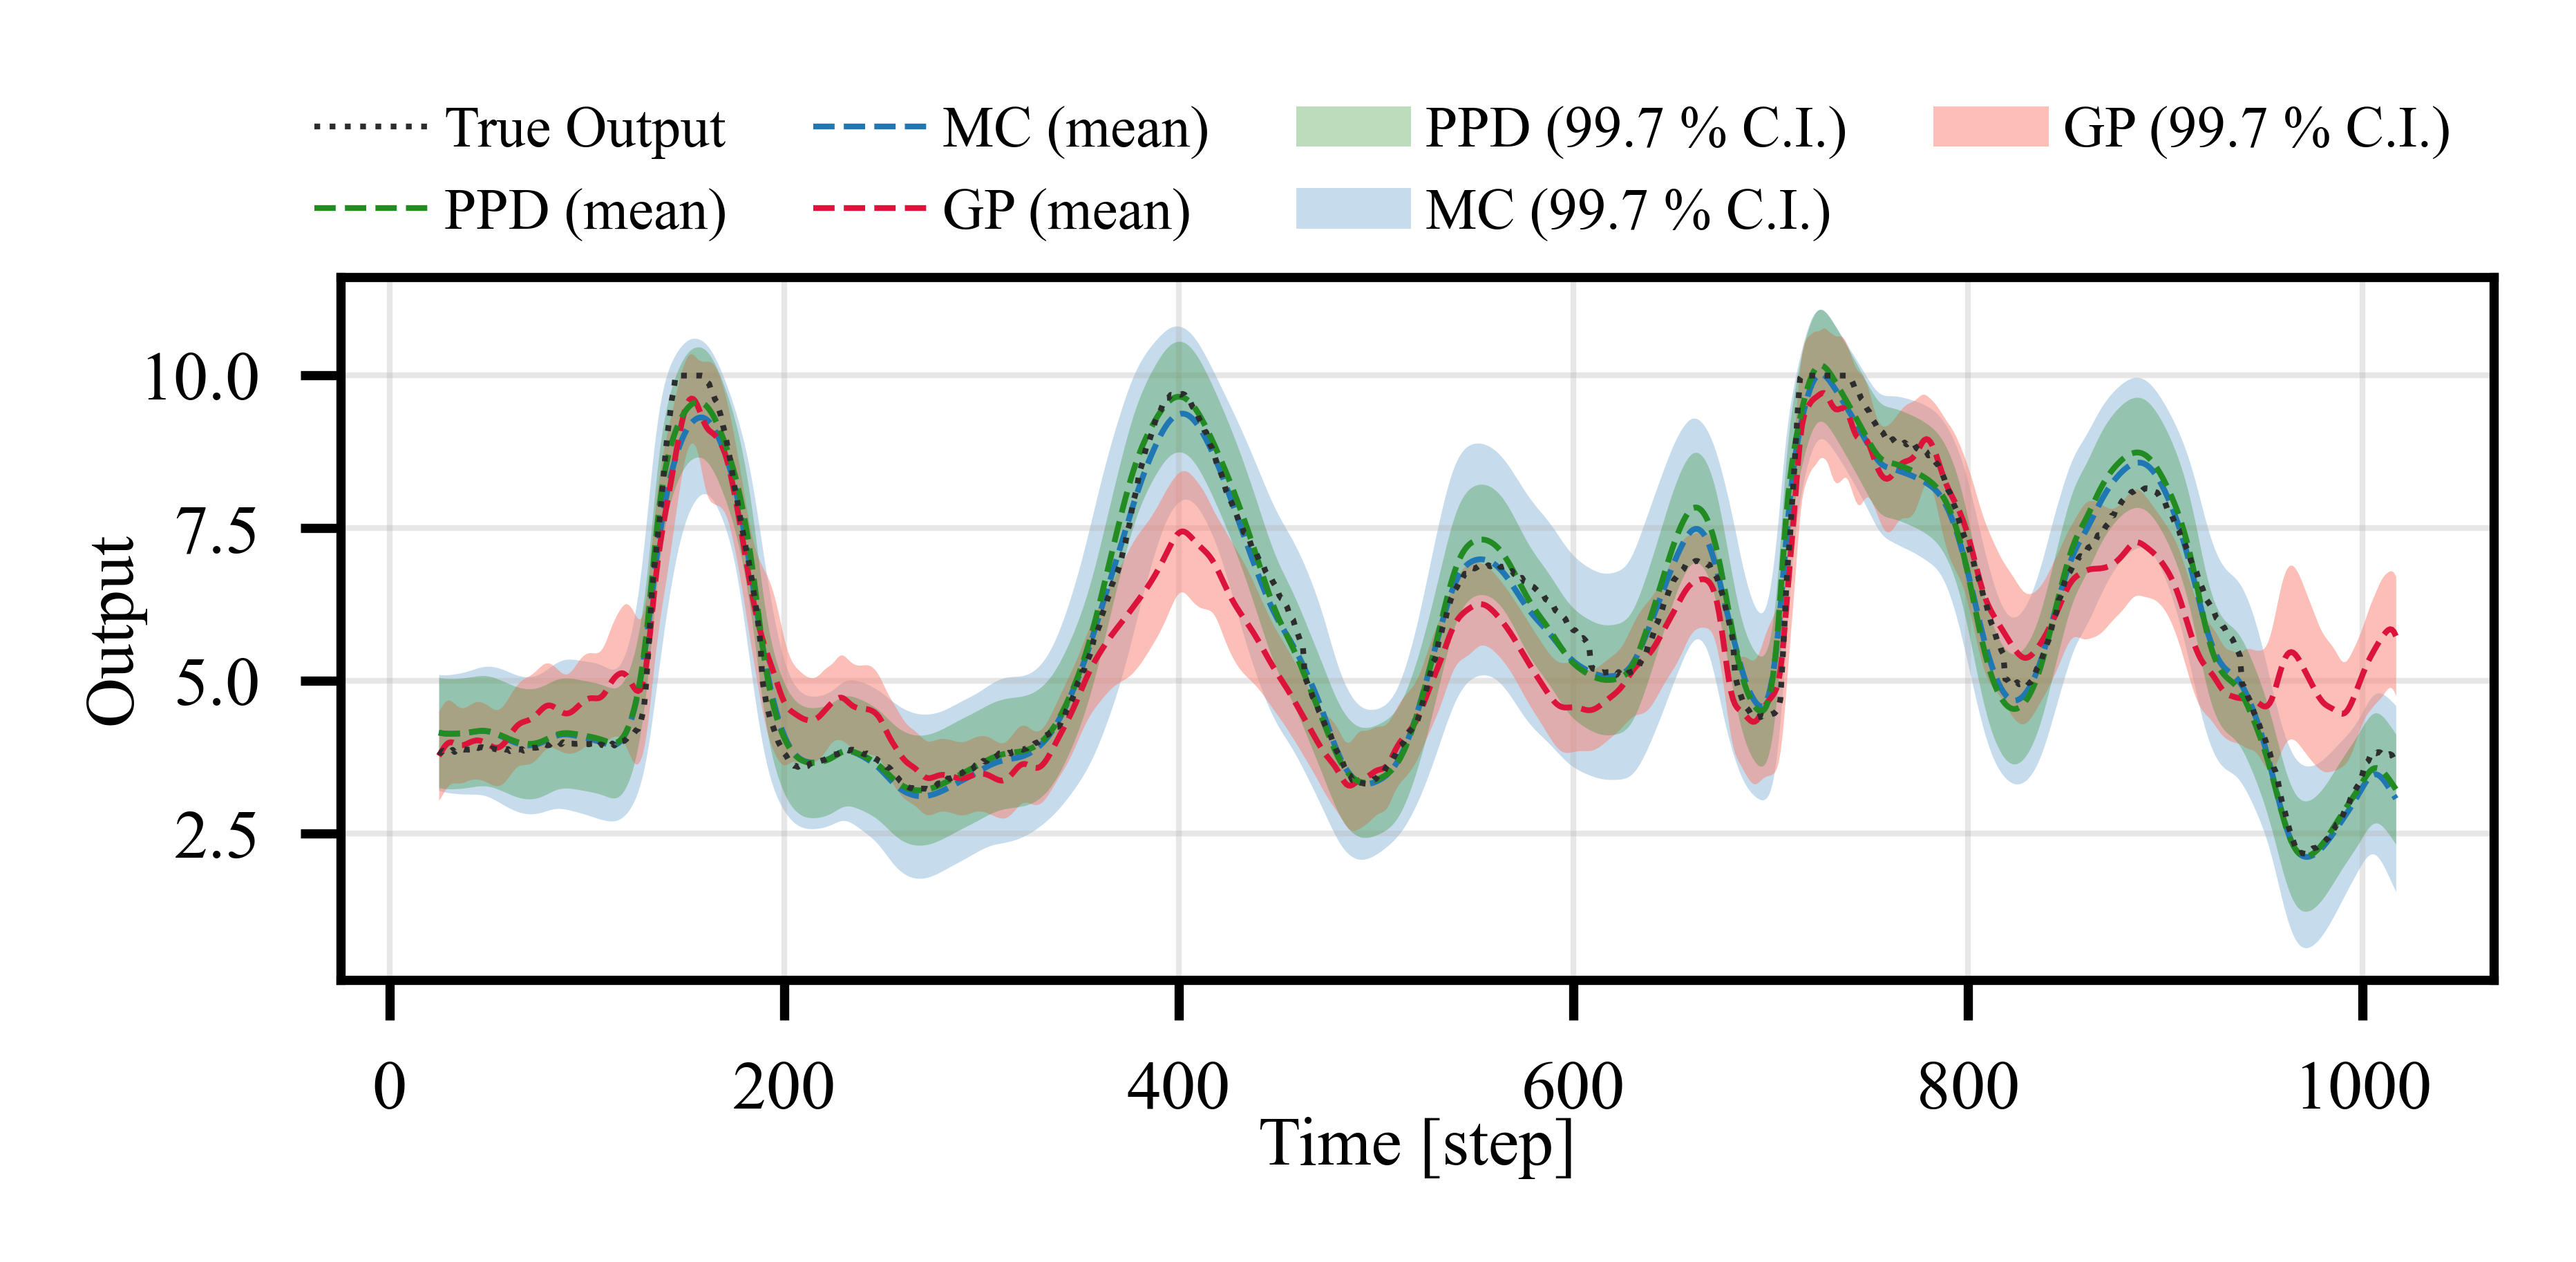

In [9]:
lw = 0.5  # Line width
dpi = 1200
fs = 6
n_skip = lag_y
# Configure font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = fs
plt.rcParams.update({'font.size': fs})
colors = ["#2D2D2D", "#1F77B4", "#228B22", "salmon", "blue", "#8AA7C1", "crimson"]

# Configure font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = fs
plt.rcParams.update({'font.size': fs})

fig, ax1 = plt.subplots(figsize=(3.35, 1.1), dpi=dpi)
ax1.plot(np.arange(y_query_test_denorm.shape[0])[n_skip:], y_test_true_denorm[n_skip:], label="True Output", linestyle=':', linewidth=lw,  color=colors[0], zorder=7)
ax1.plot(np.arange(y_query_test_denorm.shape[0])[n_skip:], y_query_test_denorm[n_skip:], label="PPD (mean)", linewidth=lw, linestyle='--', color=colors[2], zorder=6)
ax1.plot(np.arange(y_query_mc_test_denorm.shape[0])[n_skip:], y_query_mc_test_denorm[n_skip:], label="MC (mean)", linewidth=lw, linestyle='--', color=colors[1], zorder=4)
ax1.plot(np.arange(y_query_test_denorm.shape[0])[lag_y:], y_query_gp_test_denorm, label="GP (mean)", linewidth=lw, linestyle='--', color=colors[6], zorder=5)

ax1.fill_between(np.arange(y_query_test_denorm.shape[0])[n_skip:], y_query_test_denorm[n_skip:].ravel() - ppd_std_multiplier * ppd_std_test_denorm[n_skip:].ravel(),
                 y_query_test_denorm[n_skip:].ravel() + ppd_std_multiplier * ppd_std_test_denorm[n_skip:].ravel(),
                 color=colors[2], alpha=0.3, label="PPD (99.7 % C.I.)", linewidth=0, zorder=3)

ax1.fill_between(np.arange(y_query_mc_test_denorm.shape[0])[n_skip:], y_query_mc_test_denorm[n_skip:].ravel() - ppd_std_multiplier * ppd_std_mc_test_denorm[n_skip:].ravel(),
                 y_query_mc_test_denorm[n_skip:].ravel() + ppd_std_multiplier * ppd_std_mc_test_denorm[n_skip:].ravel(),
                 color=colors[1], alpha=0.25, label="MC (99.7 % C.I.)", linewidth=0, zorder=1)

ax1.fill_between(np.arange(y_query_test_denorm.shape[0])[lag_y:], y_query_gp_test_denorm.ravel() - ppd_std_multiplier * ppd_std_gp_test_denorm.ravel(),
                 y_query_gp_test_denorm.ravel() + ppd_std_multiplier * ppd_std_gp_test_denorm.ravel(),
                 color=colors[3], alpha=0.5, label="GP (99.7 % C.I.)", linewidth=0, zorder=2)

ax1.set_ylabel("Output", labelpad=-0.5)
ax1.set_xlabel("Time [step]", labelpad=-0.5)
ax1.grid(True, alpha=0.3, linewidth=0.5)
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.125), ncol=4, fontsize=fs-1, frameon=False, columnspacing=1.5, handletextpad=0.25)
# plt.savefig('Prediction_Comparison.pdf', dpi=dpi, bbox_inches='tight')


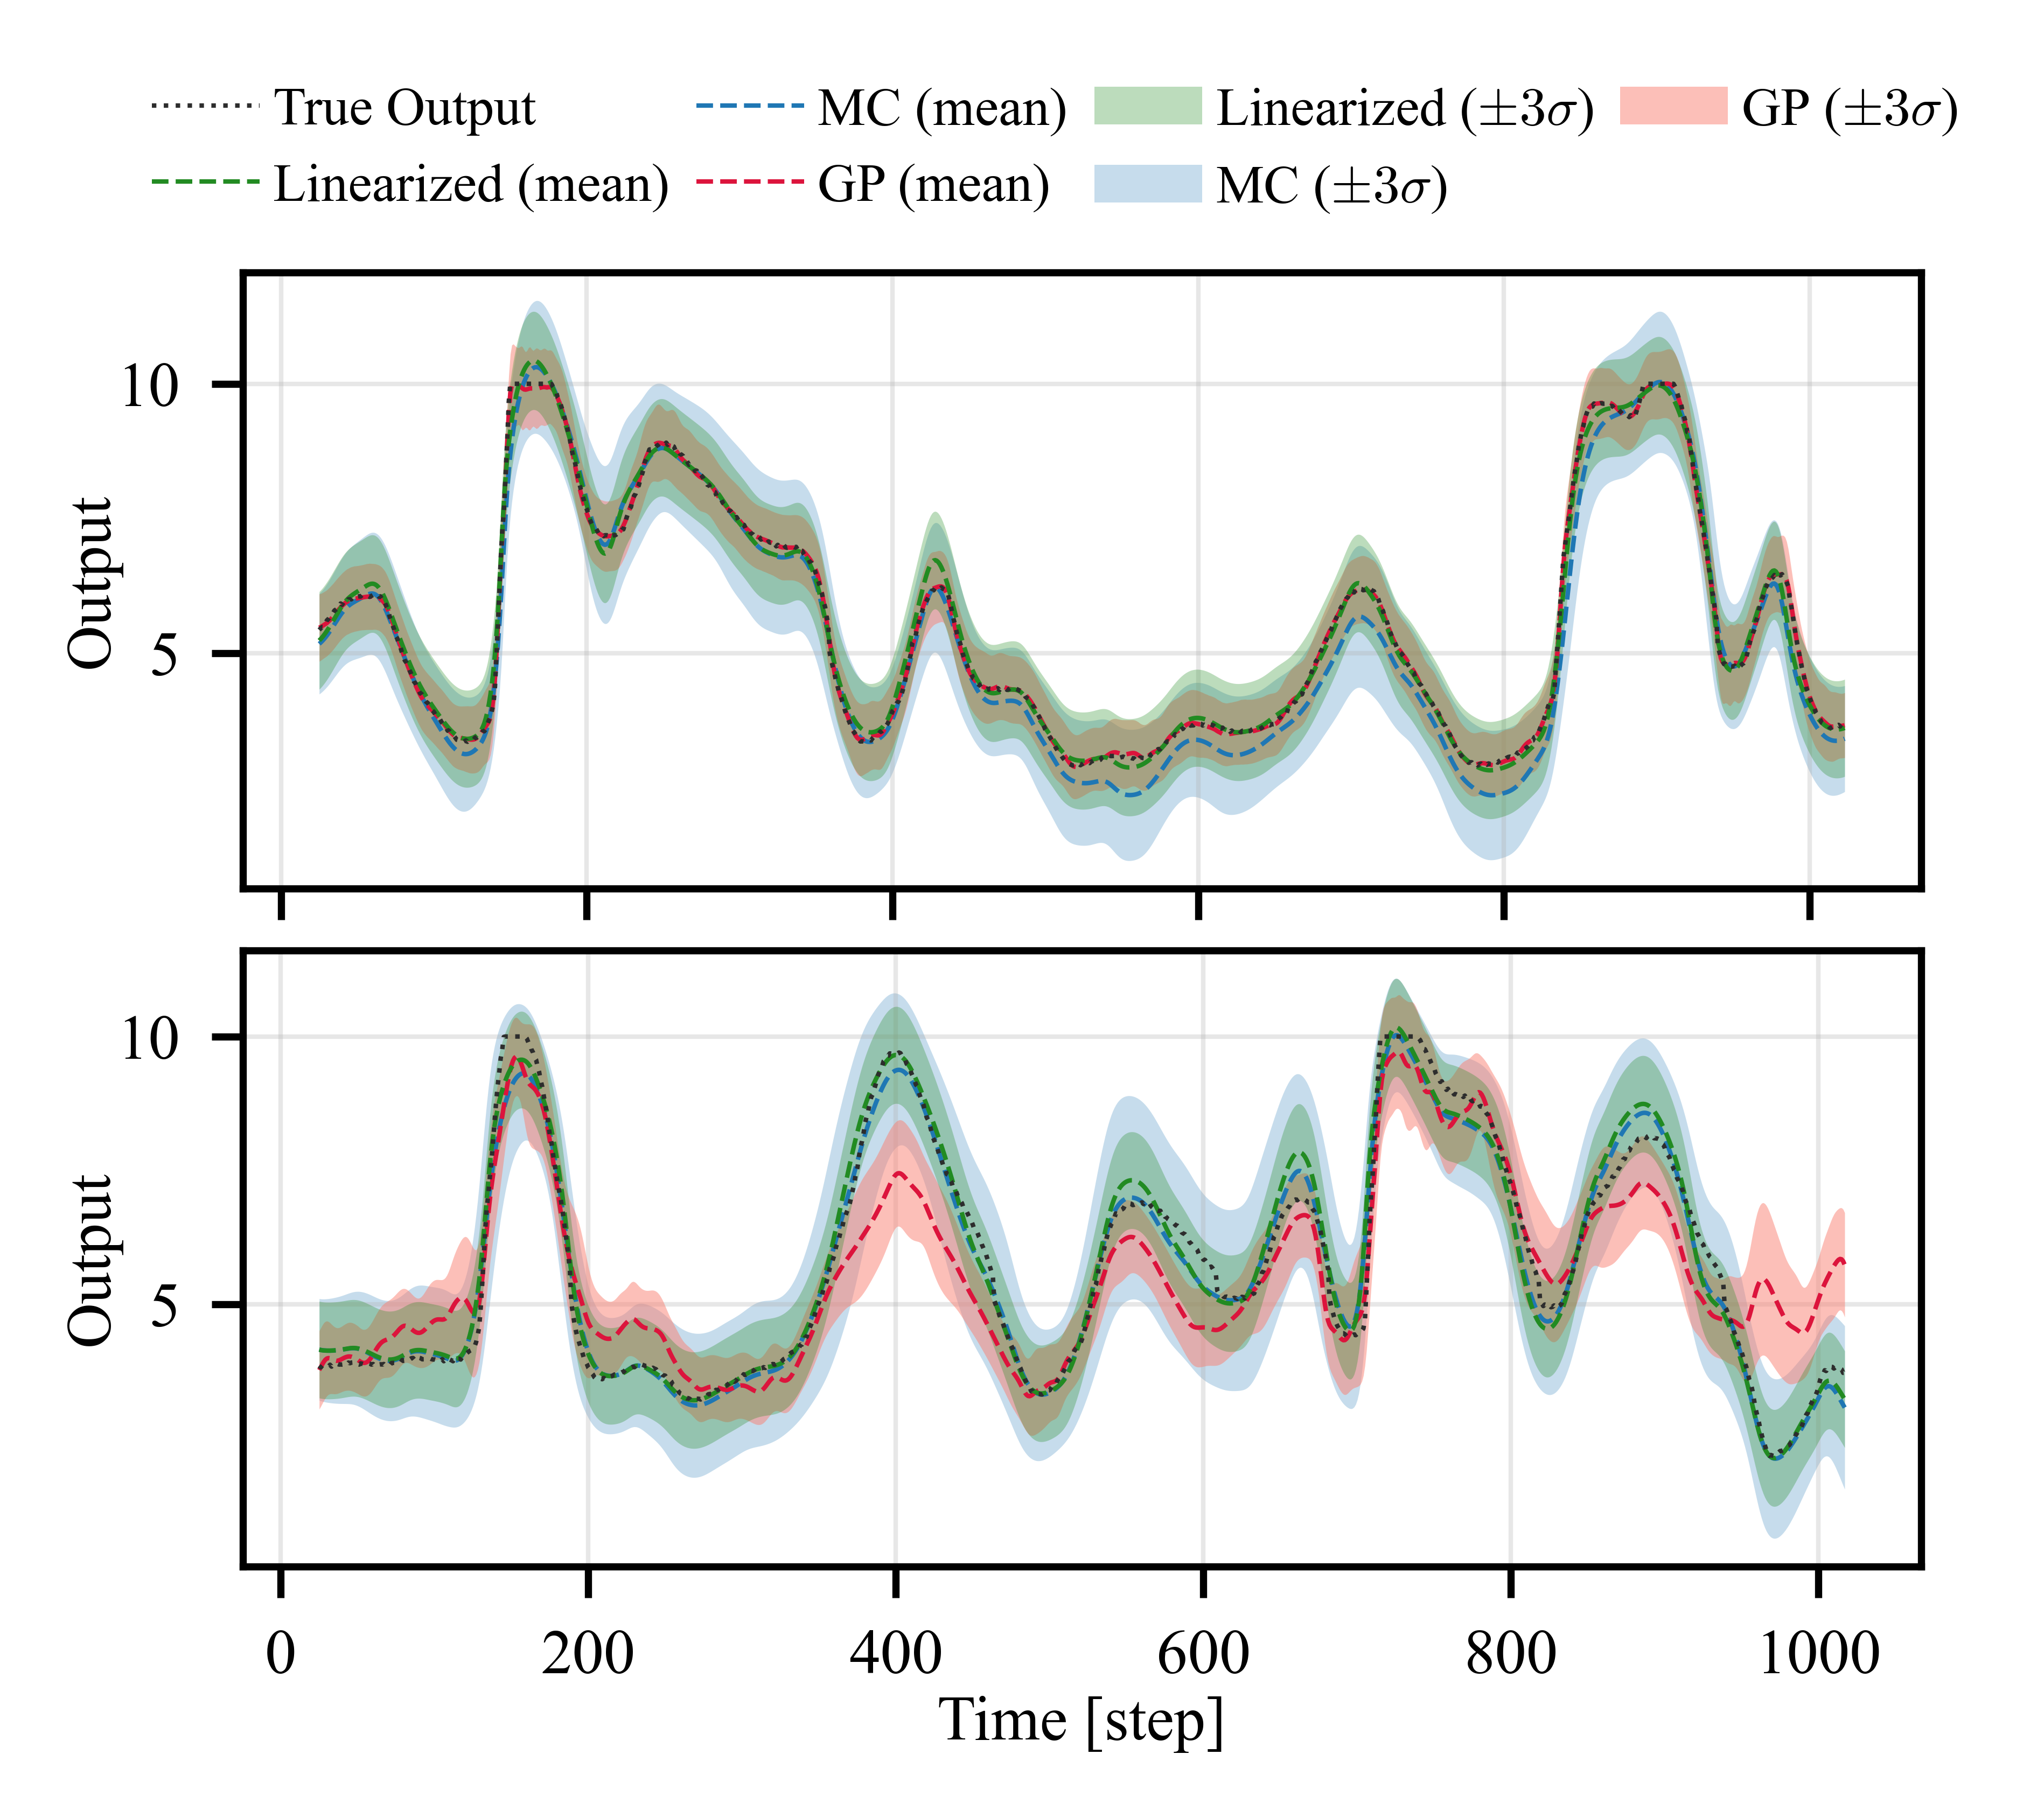

In [23]:
lw = 0.5  # Line width
dpi = 1200
fs = 7
n_skip = lag_y

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",  # Use Computer Modern
})
plt.rcParams["font.size"] = fs
plt.rcParams.update({'font.size': fs})
colors = ["#2D2D2D", "#1F77B4", "#228B22", "salmon", "blue", "#8AA7C1", "crimson"]

# Configure font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = fs
plt.rcParams.update({'font.size': fs})

fig, [ax1, ax2] = plt.subplots(2,1, figsize=(3.35, 2.6), dpi=dpi)


ax1.plot(np.arange(y_fit_true_denorm.shape[0])[n_skip:], y_fit_true_denorm[n_skip:], label="True Output", linestyle=':', linewidth=lw,  color=colors[0], zorder=7)
ax1.plot(np.arange(y_query_fit_denorm.shape[0])[n_skip:], y_query_fit_denorm[n_skip:], label="Linearized (mean)", linewidth=lw, linestyle='--', color=colors[2], zorder=6)
ax1.plot(np.arange(y_query_mc_fit_denorm.shape[0])[n_skip:], y_query_mc_fit_denorm[n_skip:], label="MC (mean)", linewidth=lw, linestyle='--', color=colors[1], zorder=4)
ax1.plot(np.arange(y_query_fit_denorm.shape[0])[lag_y: ], y_query_gp_fit_denorm, label="GP (mean)", linewidth=lw, linestyle='--', color=colors[6], zorder=5)

ax1.fill_between(np.arange(y_query_fit_denorm.shape[0])[n_skip:], y_query_fit_denorm[n_skip:].ravel() - ppd_std_multiplier * ppd_std_fit_denorm[n_skip:].ravel(),
                 y_query_fit_denorm[n_skip:].ravel() + ppd_std_multiplier * ppd_std_fit_denorm[n_skip:].ravel(),
                 color=colors[2], alpha=0.3, label=r"Linearized ($\pm 3\sigma$)", linewidth=0, zorder=3)
ax1.fill_between(np.arange(y_query_mc_fit_denorm.shape[0])[n_skip:], y_query_mc_fit_denorm[n_skip:].ravel() - ppd_std_multiplier * ppd_std_mc_fit_denorm[n_skip:].ravel(),
                 y_query_mc_fit_denorm[n_skip:].ravel() + ppd_std_multiplier * ppd_std_mc_fit_denorm[n_skip:].ravel(),
                 color=colors[1], alpha=0.25, label=r"MC ($\pm 3\sigma$)", linewidth=0, zorder=1)
ax1.fill_between(np.arange(y_query_fit_denorm.shape[0])[lag_y:], y_query_gp_fit_denorm.ravel() - ppd_std_multiplier * ppd_std_gp_fit_denorm.ravel(),
                 y_query_gp_fit_denorm.ravel() + ppd_std_multiplier * ppd_std_gp_fit_denorm.ravel(),
                 color=colors[3], alpha=0.5, label=r"GP ($\pm 3\sigma$)", linewidth=0, zorder=2)

# ax1.set_xticks([])
ax1.tick_params(labelbottom=False)
ax1.grid(True, alpha=0.3, linewidth=0.5)


ax2.plot(np.arange(y_query_test_denorm.shape[0])[n_skip:], y_test_true_denorm[n_skip:], linestyle=':', linewidth=lw,  color=colors[0], zorder=7)
ax2.plot(np.arange(y_query_test_denorm.shape[0])[n_skip:], y_query_test_denorm[n_skip:], linewidth=lw, linestyle='--', color=colors[2], zorder=6)
ax2.plot(np.arange(y_query_mc_test_denorm.shape[0])[n_skip:], y_query_mc_test_denorm[n_skip:], linewidth=lw, linestyle='--', color=colors[1], zorder=4)
ax2.plot(np.arange(y_query_test_denorm.shape[0])[lag_y:], y_query_gp_test_denorm, linewidth=lw, linestyle='--', color=colors[6], zorder=5)

ax2.fill_between(np.arange(y_query_test_denorm.shape[0])[n_skip:], y_query_test_denorm[n_skip:].ravel() - ppd_std_multiplier * ppd_std_test_denorm[n_skip:].ravel(),
                 y_query_test_denorm[n_skip:].ravel() + ppd_std_multiplier * ppd_std_test_denorm[n_skip:].ravel(),
                 color=colors[2], alpha=0.3,  linewidth=0, zorder=3)

ax2.fill_between(np.arange(y_query_mc_test_denorm.shape[0])[n_skip:], y_query_mc_test_denorm[n_skip:].ravel() - ppd_std_multiplier * ppd_std_mc_test_denorm[n_skip:].ravel(),
                 y_query_mc_test_denorm[n_skip:].ravel() + ppd_std_multiplier * ppd_std_mc_test_denorm[n_skip:].ravel(),
                 color=colors[1], alpha=0.25,  linewidth=0, zorder=1)

ax2.fill_between(np.arange(y_query_test_denorm.shape[0])[lag_y:], y_query_gp_test_denorm.ravel() - ppd_std_multiplier * ppd_std_gp_test_denorm.ravel(),
                 y_query_gp_test_denorm.ravel() + ppd_std_multiplier * ppd_std_gp_test_denorm.ravel(),
                 color=colors[3], alpha=0.5, linewidth=0, zorder=2)

ax1.set_ylabel("Output", labelpad=-0.5)
ax2.set_ylabel("Output", labelpad=-0.5)
ax2.set_xlabel("Time [step]", labelpad=1)
ax2.grid(True, alpha=0.3, linewidth=0.5)
plt.subplots_adjust(hspace=0.1)
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=4, fontsize=fs-1, frameon=False, columnspacing=0.5, handletextpad=0.25)
plt.savefig('Prediction_Comparison_Extended.pdf', dpi=dpi, bbox_inches='tight')


In [11]:
RMSE_test = np.sqrt(np.mean((y_query_test_denorm - y_test_true_denorm) ** 2))
RMSE_test_mc = np.sqrt(np.mean((y_query_mc_test_denorm - y_test_true_denorm) ** 2))
RMSE_test_gp = np.sqrt(np.mean((y_query_gp_test_denorm - y_test_true_denorm) ** 2)) 

print(f"RMSE Test PPD: {RMSE_test:.4f}")
print(f"RMSE Test MC: {RMSE_test_mc:.4f}")
print(f"RMSE Test GP: {RMSE_test_gp:.4f}")

RMSE Test PPD: 0.3647
RMSE Test MC: 0.3396
RMSE Test GP: 2.6590
